<a href="https://colab.research.google.com/github/HakanBayazitHabes/Feeling_Detection_CNN/blob/master/FeelingDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YÜZ GÖRÜTNÜLERİNDEN DERİN ÖĞRENME İLE DUYGU TANIMA UYGULAMASI

---



*   Programlama Dili: Python
*   Kütüphane: Keras/Tensorflow
*   Donanım/Bulut: google Cloud, ücretsiz Colab servisi
*   Veri Seti: Dataset
*   Yöntem: Derin Öğrenme
*   Model: 5 Evrişimli Katmanlı Sinir ağları Modeli

---

Ek Kaynakalar:


1.   [Ön İşlemler](https://github.com/Hanzhuo/Facial-Expression-Recognition-with-TensorFlow-Convolutional-Neural-Networks/blob/master/CNN_Facial_Expression_Recogonition.ipynb)
2.   [Eğitim ve Model](https://github.com/piyush2896/Facial-Expression-Recognition-Challenge/blob/master/Facial-Expression-Recognition-Challenge.ipynb)
3.   [Görselleştirme ve ek tanımlamalar](https://github.com/sachin-kmr/ML-Facial-Expression-Recognition/blob/master/exp_recognition.ipynb)





## Google Colab Kimlik Doğrulama İşlemi
Klasik Colab kimlik doğrulaam işlemi ile başlayalım!

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import os

os.chdir('/gdrive/My Drive/Feeling_Detection')

In [3]:
!ls

data  Duygu_Tanima.ipynb  FeelingDetection.ipynb  images  utils


### **UYGULAMA BAŞLANGICI**
Gerekli paketlerin yüklenmesi...

In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.utils import to_categorical

import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing import image # ön işleme için kullanılacak
from keras.callbacks import ModelCheckpoint # Checkpointler eğitim aşamsında kullanıcaz

**Veri setinin okunması...**

Bize verilen veriseti **35887 ** satır ve **3** sütundan oluşuyor.

In [5]:
root = '/gdrive/My Drive/Feeling_Detection/'

data = pd.read_csv(root + 'data/fer2013/fer2013.csv')
data.shape

(35887, 3)

### **Veriden bir kısım görelim**

In [6]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
data["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Usage kolununda verisetindeki örnekler kaç gruba ayrıldığını görebilirz. Kaggleda genelde bu şekilde submit sonrası asıl test edilemsi için verisetinden bir kısmını "PrivateTest" olarak ayırırlar.

## EĞİTİM VERİSİ İÇİN ÖN İŞLEME ADIMLARI

Eğitim işlemi için veri kümesinde ayrılmış olan **Training** kısmını alıyoruz.

In [8]:
unique_values = np.unique(data["Usage"].values.ravel())
print('Eğitim setindeki örnek sayısı: %d'%(len(data[data.Usage == "Training"])))

print("Benzersiz değerler:", unique_values)

Eğitim setindeki örnek sayısı: 28709
Benzersiz değerler: ['PrivateTest' 'PublicTest' 'Training']


Eğitim işlemi için veri kümesinde ayrılmış olan **Training** kısmını alıyoruz

In [9]:
train_data = data[data.Usage == "Training"] # Sadece eğitim örnekelrini train_data değişkenine aldık
print(train_data.pixels.head())


0    70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1    151 150 147 155 148 133 111 140 170 174 182 15...
2    231 212 156 164 174 138 161 173 182 200 106 38...
3    24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4    4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
Name: pixels, dtype: object


In [10]:
# Eğitim örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
train_pixels = train_data.pixels.str.split(" ").tolist()

train_pixels = pd.DataFrame(train_pixels, dtype=int)
train_images = train_pixels.values
train_images = train_images.astype(np.float)

print(train_images)
print(train_images.shape)

<ipython-input-10-330c689d96c3>:4: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  train_pixels = pd.DataFrame(train_pixels, dtype=int)
<ipython-input-10-330c689d96c3>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_images = train_images.astype(np.float)


[[ 70.  80.  82. ... 106. 109.  82.]
 [151. 150. 147. ... 193. 183. 184.]
 [231. 212. 156. ...  88. 110. 152.]
 ...
 [ 74.  81.  87. ... 188. 187. 187.]
 [222. 227. 203. ... 136. 136. 134.]
 [195. 199. 205. ...   6.  15.  38.]]
(28709, 2304)


In [11]:
# Görüntüyü 48x48 piksel şeklinde göstermek için bir fonksiyon tanımlayalım
def show(img):
  show_image = img.reshape(48,48)
  plt.imshow(show_image, cmap='gray')
  plt.axis('off')
  plt.show()

### **Eğitim kümesinde bir örnek görsel**

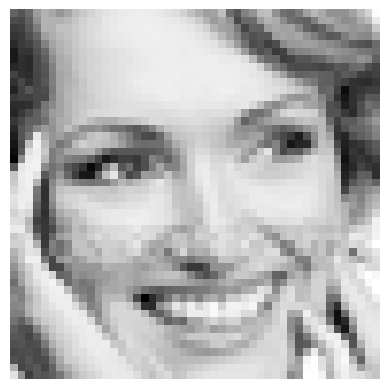

In [12]:
# Veri kümesinde
show(train_images[28687])

### **Eğitim kümesinde kaç sınıf bulunuyor bunu görelim.**

In [13]:
train_labels_flat = train_data["emotion"].values.ravel()
train_labels_count = np.unique(train_labels_flat).shape[0]
print('Farklı yüz ifadelerinin sayısı: %d'%train_labels_count)

Farklı yüz ifadelerinin sayısı: 7


### **One Hot ile eğitim kümesindeki verilerin her birini düşen sınıfı yani eğitim işlemi boyutunu görelim**

In [14]:
def dense_to_one_hot(labels_dense, num_classes):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

In [15]:
y_train = dense_to_one_hot(train_labels_flat, train_labels_count)

y_train = y_train.astype(np.uint8)

print(y_train.shape)

(28709, 7)


# TEST VERİSİ ÖN İŞLEME ADIMLARI

In [16]:
np.unique(data["Usage"].values.ravel())

print('Test setindeki örnek sayısı: %d'%(len(data[data.Usage == "PublicTest"])))

Test setindeki örnek sayısı: 3589


Eğitim işlemi için veri kümesinde ayrılmış olan **PublicTest** kısmını alıyoruz.

In [17]:
# Test örneklerinin piksel değerleri bize tablo halinde yan yana verildiği için boşluklardan parse ederek liste olarak değişkene aldık
test_data = data[data.Usage == "PublicTest"]
test_pixels = test_data.pixels.str.split(" ").tolist()

test_pixels = pd.DataFrame(test_pixels, dtype=int)
test_images = test_pixels.values
test_images = test_images.astype(np.float)

print(test_images)
print(test_images.shape)

<ipython-input-17-9144bb030785>:5: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  test_pixels = pd.DataFrame(test_pixels, dtype=int)


[[254. 254. 254. ...  42. 129. 180.]
 [156. 184. 198. ... 172. 167. 161.]
 [ 69. 118.  61. ...  88.  87.  90.]
 ...
 [255. 255. 255. ...  48.  50.  46.]
 [ 33.  25.  31. ...   4.   5.   4.]
 [ 61.  63.  59. ... 113. 165. 180.]]
(3589, 2304)


<ipython-input-17-9144bb030785>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_images = test_images.astype(np.float)


Eğitim kümseinde bir örnek görsel

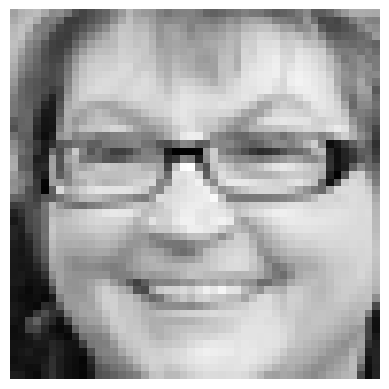

In [18]:
# Bir test örneği gösterelim
show(test_images[100])

One hot ile test kümesindeki verikerin her birine düşen sınıfı yani eğitim işlemi boyutunu görelim

In [19]:
test_labels_flat = test_data["emotion"].values.ravel()
test_labels_count = np.unique(test_labels_flat).shape[0]

y_test = dense_to_one_hot(test_labels_flat, test_labels_count)

y_test= y_test.astype(np.uint8)

print(y_test.shape)

(3589, 7)


# TEST KÜMESİNDE RNEK GÖRÜNTÜLER

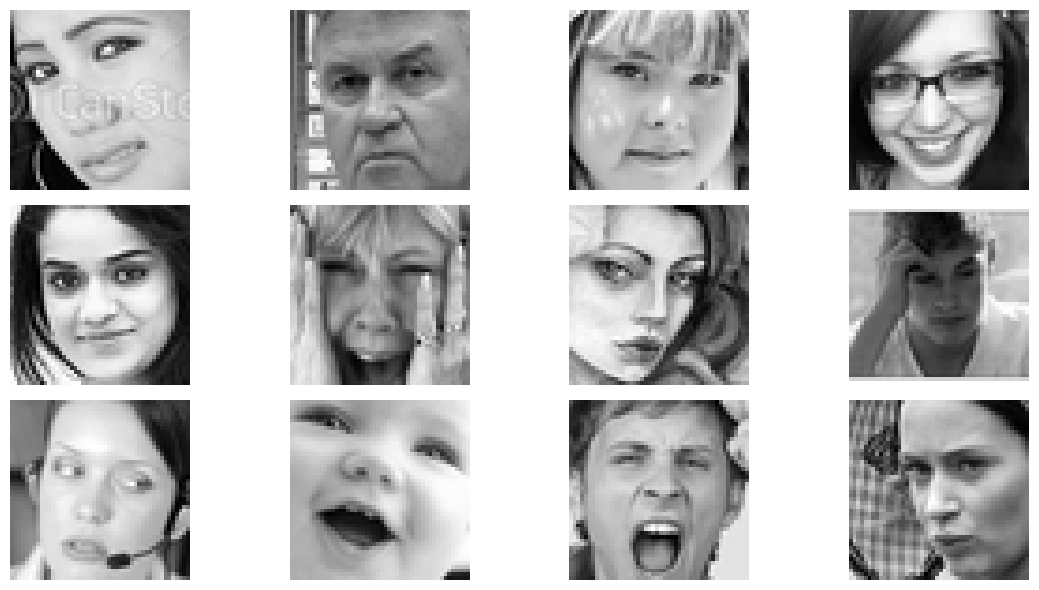

In [20]:
# test versetinden örnekler bir kaçını toplu halde görelim
plt.figure(0, figsize=(12, 6))
for i in range(1, 13):
  plt.subplot(3 ,4, i)
  plt.axis('off')

  image = test_images[i].reshape(48, 48)
  plt.imshow(image, cmap='gray')

plt.tight_layout()
plt.show()

# DERİN EVRİŞİMLİ SİNİR AĞI MODELİ TANIMLANMASI

Kullandığımız modeli gerçekleştirirsek:

---



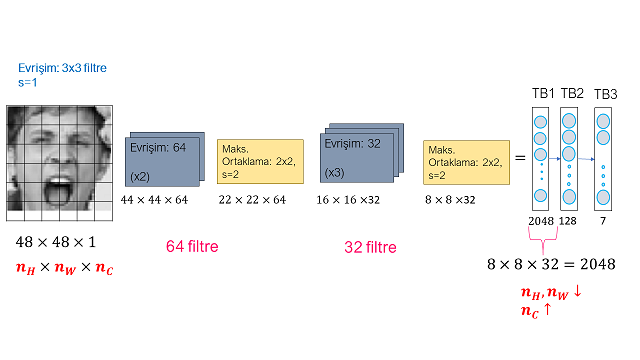

### Görseldeki Modeli Yazalım

In [21]:
model = Sequential()

# 1. KATMAN
model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal", input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 2. KATMAN
model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides = 2))
model.add(Dropout(0,6)) # %60 unutma işlemi(nöron silme-dropout)

# 3. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 4. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5. KATMAN
model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0,6)) # %60 unutma işlemi (nöron silme-dopout)


### TAM BAĞIMSIZ KATMANI
model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6)) # %60 unutma işlemi (nöron silme-dopout)

### ÇIKIŞ KATMANI
model.add(Dense(7))
model.add(Activation('softmax')) # Sınıflama işlemi (7 duygu sınıfı var)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizasyon ve başarım hesaplama metirklerinin belirlenmesi
model.summary() # model özetini görselleştirme

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 44, 44, 64)        256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 44, 44, 64)        0

### Eğitim ve Test kümelerinin eleman sayısı, yükseklik ve genişlik ve kanalsayısı bilgilerini ekrana yazdıralım

In [22]:
x_train = train_images.reshape(-1, 48, 48, 1) # Burada -1 verme nedenimiz veri boyutu bildemediğimiz zaman -1 yazarsak otomatik oalrka kendisi bulacaktır
x_test = test_images.reshape(-1, 48, 48, 1)   #  ''         ''      ''      ''    ''        ''         ''       ''        ''      ''      ''      ''

print('Train:', x_train.shape)
print('Test:', x_test.shape)

Train: (28709, 48, 48, 1)
Test: (3589, 48, 48, 1)


### Eğitim ve Test kümelerinin eleman ve duygu sınıf sayısı

In [23]:
print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (28709, 7)
Test: (3589, 7)


### Eğitim işleminin gerçekleşmesini istediğimiz epoch, batchsize gibi değerlerin belirlenmesi ve eğitim sonucunda ağırlıkların .h5 dosyası olarak kaydedilmesi işlemleri

In [24]:
# en başarılı ağırlıkları kaydet
checkpointer = ModelCheckpoint(filepath=root + 'data/face_model.h5', verbose=1, save_best_only=True)

epochs = 10
batchSize = 100

# model çalıştırılması
hist = model.fit(x_train, y_train,
                 epochs=epochs,
                 shuffle=True,
                 batch_size=batchSize,
                 validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open(root + 'data/face_model.json', 'w') as json_file:
  json_file.write(model_json)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.44756, saving model to /gdrive/My Drive/Feeling_Detection/data/face_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


288/288 - 27s - loss: 1.7633 - accuracy: 0.3472 - val_loss: 1.4476 - val_accuracy: 0.4369 - 27s/epoch - 93ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.44756 to 1.33296, saving model to /gdrive/My Drive/Feeling_Detection/data/face_model.h5
288/288 - 8s - loss: 1.3945 - accuracy: 0.4679 - val_loss: 1.3330 - val_accuracy: 0.4831 - 8s/epoch - 29ms/step
Epoch 3/10

Epoch 3: val_loss improved from 1.33296 to 1.27357, saving model to /gdrive/My Drive/Feeling_Detection/data/face_model.h5
288/288 - 9s - loss: 1.2836 - accuracy: 0.5118 - val_loss: 1.2736 - val_accuracy: 0.5060 - 9s/epoch - 31ms/step
Epoch 4/10

Epoch 4: val_loss improved from 1.27357 to 1.20573, saving model to /gdrive/My Drive/Feeling_Detection/data/face_model.h5
288/288 - 8s - loss: 1.2111 - accuracy: 0.5405 - val_loss: 1.2057 - val_accuracy: 0.5339 - 8s/epoch - 28ms/step
Epoch 5/10

Epoch 5: val_loss did not improve from 1.20573
288/288 - 8s - loss: 1.1603 - accuracy: 0.5597 - val_loss: 1.2251 - val_accuracy: 0.5325 

### Eğitim sonucu elde edilen Eğitim ve Geçerleme (Validation) sonuçlarının grafiksel olarak ifade edilip ekrarna yazdırılması işlemleri.

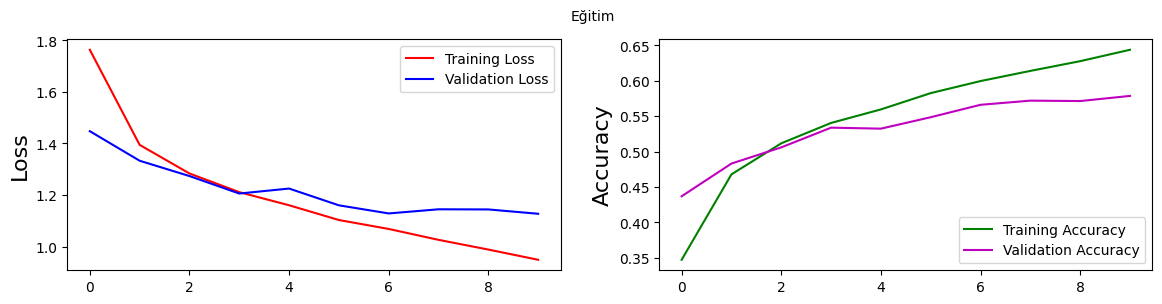

In [33]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Eğitim', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color ='r', label='Training Loss')
plt.plot(hist.history['val_loss'], color ='b', label='Validation Loss')
plt.legend(loc='upper right')


plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color ='g', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color ='m', label='Validation Accuracy')
plt.legend(loc='lower right')

plt.show()

### Kaggle submit edecek gibi PrivateTest örnekleri ile test edelim.

In [34]:
test = data[["emotion", "pixels"]][data["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))

test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [35]:

x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [36]:

x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

In [37]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)
print("PrivateTest üzerindeki doğruluk durumu:", score)

PrivateTest üzerindeki doğruluk durumu: [1.1204373836517334, 0.5812203884124756]


### Veri kümseindeki eğitim kısmı ile modeli eğitip test için ayırılan veri ile test işlemlerini yaptık.


---



## Farklı görüntülerle test işlemlerini yapıp sonuçları görselleştirelim.

In [38]:
from keras.models import load_model
from PIL import Image
from keras.preprocessing import image

### Daha önceki eğitimde kaydettiğimiz modelin hesapladığını öğrenilmiş ağırlık dosyasını kullanıyoruz.

In [39]:
# en iyi ağırlıkları yükle
model_best = load_model(root + 'data/face_model.h5')

In [40]:
os.chdir('/gdrive/My Drive/Feeling_Detection/images')

In [41]:
!ls


brando.png  hababam.jpg        javierbardem.jpg  robertdeniro.jpg
emojis	    javierbardem2.jpg  kemal_sunal2.jpg


In [42]:
#test_image=x_test_private[60] #eğer veri kümesinden bir görsel denemek isterseniz burada [] içine rastgele bir görsel numarası atayarak test edebilirsiniz!

image_path = root + "images/brando.png"

test_image_original = image.load_img(image_path) # orjinal renkli görüntü

test_image = image.load_img(image_path, target_size=(48, 48), grayscale=True)
test_data = image.img_to_array(test_image)

test_data = np.expand_dims(test_data, axis=0)
test_data = np.vstack([test_data])

results = model_best.predict(test_data, batch_size=1)
results


/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 304ms/step


array([[5.8901183e-02, 1.9581633e-04, 3.2007433e-02, 3.9621326e-01,
        2.8265211e-01, 3.3873306e-03, 2.2664285e-01]], dtype=float32)

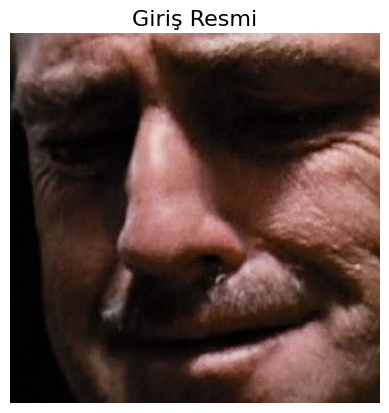

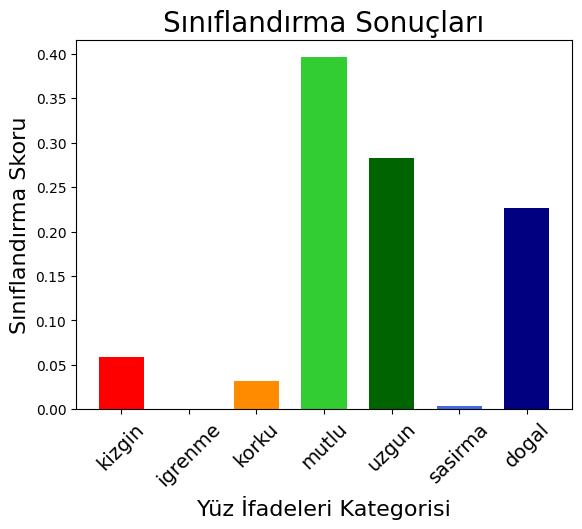

Sınıflandırma sonucu en yüksek oranla: mutlu


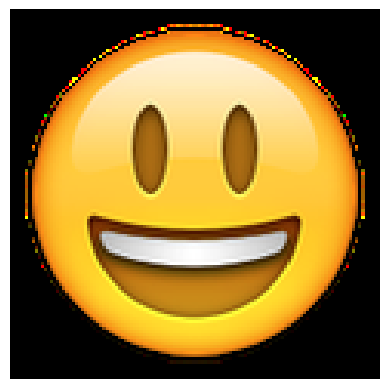

In [43]:
#sınıflarımız 7 adet duygu durumumuz
class_names = ['kizgin', 'igrenme', 'korku', 'mutlu', 'uzgun', 'sasirma', 'dogal']

ind = 0.1+0.6*np.arange(len(class_names))
width = 0.4  #bar genişliği

color_list = ['red','orangered','darkorange','limegreen','darkgreen','royalblue','navy']

# test resmimizi çizdirelim

plt.imshow(test_image_original)
plt.title('Giriş Resmi', fontsize=16)
plt.axis('off')
plt.show()

#sonuçlarımızı renklendirelim

for i in range(len(class_names)):
  plt.bar(ind[i], results[0][i], width, color=color_list[i])

plt.title("Sınıflandırma Sonuçları", fontsize=20)
plt.xlabel("Yüz İfadeleri Kategorisi",fontsize=16)
plt.ylabel("Sınıflandırma Skoru",fontsize=16)
plt.xticks(ind, class_names, rotation=45, fontsize=14)
plt.show()


print("Sınıflandırma sonucu en yüksek oranla:", class_names[np.argmax(results)])

# en yüksek skorlu duyguya karşılık emoji çizdirelim

emojis_img = image.load_img(root + 'images/emojis/%s.png'% str(class_names[np.argmax(results)]))

plt.imshow(emojis_img)
plt.axis('off')
plt.show()